# The Impact of Mental Health on Suicide Rates Across Countries

### Authors: Nick Ng, Kevin Tat, Keaton Staggs

In [299]:
!pip install geopandas
!pip install seaborn
!pip install plotly

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
   ---- ----------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
   --------- ----------------------------- 71.7/294.9 kB 491.5 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/294.9 kB 654.9 kB/s eta 0:00:01
   ------------------------------------- -- 276.5/294.9 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.2 MB/s eta 0:00:00


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px


In [2]:
suicide_data = pd.read_csv("combined_processed_data.csv")
gdp_data = pd.read_csv("gdp_1960_2020.csv")
WHO_data = pd.read_csv("GHED_data.csv", encoding='latin1')
mental_health_data = pd.read_csv("mental_disorder_data_cleaned.csv")

C:\Users\theaw\AppData\Local\Temp\ipykernel_16692\743709329.py:3: DtypeWarning: Columns (6,22,23,24,36,38,102,103,104,105,109,110,111,117,119,125,126,127,128,132,133,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,240,241,242,243,244,245,247,248,249,250,251,253,254,255,256,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,34

## Data Cleaning

In [3]:
def clean_country_name(s):
    if "United States" in s and "Island" not in s:
        return "United States"
    return s

In [4]:
all_df = [suicide_data, gdp_data, WHO_data, mental_health_data]
col_name = ["Country Name", "country", "country", "country"]
countries = ["Japan", "United States", "Germany", "Egypt", "Brazil", "Australia", "Spain", "Italy", "Mexico", "Denmark"]
for i in range(len(all_df)):
    all_df[i][col_name[i]] = all_df[i][col_name[i]].apply(clean_country_name)
    all_df[i] = all_df[i].loc[all_df[i][col_name[i]].isin(countries)]

suicide_data_filtered = all_df[0]
gdp_data_filtered = all_df[1]
WHO_data_filtered = all_df[2]
mental_health_data_filtered = all_df[3]

In [5]:
gdp_suicide = suicide_data_filtered.merge(gdp_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")
WHO_suicide = suicide_data_filtered.merge(WHO_data_filtered, left_on = ["Country Name", "Year"], right_on = ["country", "year"], how = "left")
mental_suicide = suicide_data_filtered.merge(mental_health_data_filtered, left_on = ["Country Name", "Year"], right_on = ["country", "year"], how = "left")


## Basic Overview

C:\Users\theaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


Text(0.5, 1.0, 'Number of Suicide per Country From 1950 - 2020')

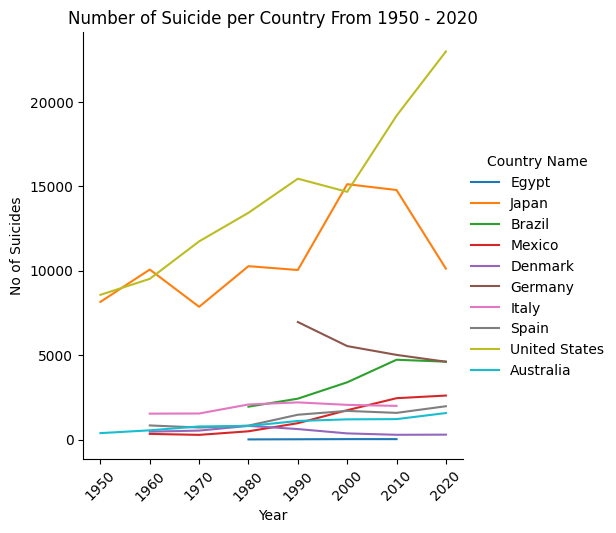

In [6]:
filtered_data = suicide_data_filtered[suicide_data_filtered['Year'] % 10 == 0]
sns.relplot(data=filtered_data, x="Year", y="No of Suicides", hue="Country Name", kind="line", ci=None)
plt.xticks(rotation=45)
plt.title("Number of Suicide per Country From 1950 - 2020")

## How does the GDP of the country contribute to suicide rates?

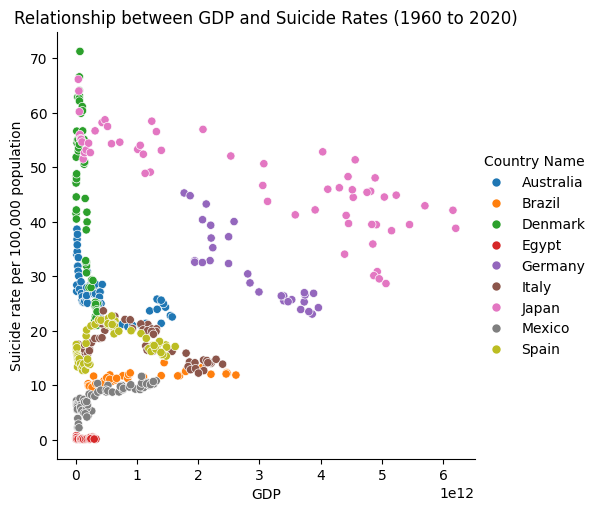

In [7]:
gdp_suicide_grouped = gdp_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
gdp_suicide_merged = gdp_suicide_grouped.merge(gdp_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")

not_us = gdp_suicide_merged[gdp_suicide_merged["Country Name"] != "United States"].dropna()
sns.relplot(data=not_us, x="gdp", y= "Death rate per 100 000 population", hue="Country Name")
plt.xlabel("GDP")
plt.ylabel("Suicide rate per 100,000 population")
plt.title(f"Relationship between GDP and Suicide Rates ({not_us['Year'].min()} to {not_us['Year'].max()})")
plt.show()


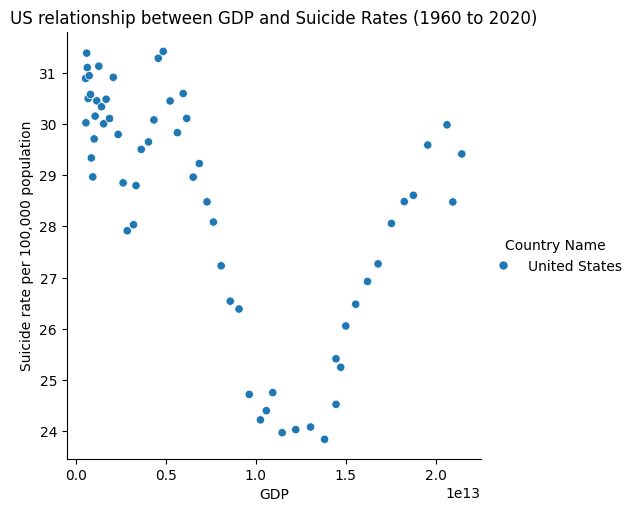

In [8]:
us = gdp_suicide_merged[gdp_suicide_merged["Country Name"] == "United States"].dropna()
sns.relplot(data=us, x="gdp", y= "Death rate per 100 000 population", hue="Country Name")
plt.xlabel("GDP")
plt.ylabel("Suicide rate per 100,000 population")
plt.title(f"US relationship between GDP and Suicide Rates ({not_us['Year'].min()} to {not_us['Year'].max()})")
plt.show()


## How does health expenditure correlate with suicide rates?


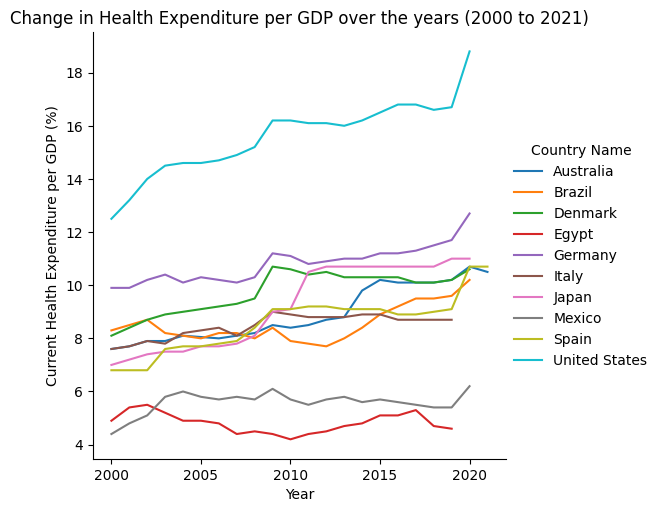

In [10]:
WHO_suicide_grouped = WHO_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
WHO_suicide_merged = WHO_suicide_grouped.merge(WHO_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")

che_data = WHO_suicide_merged[WHO_suicide_merged["che_gdp"].notna()]
sns.relplot(data = che_data, x = "Year", y = "che_gdp", hue = "Country Name", kind = "line")
plt.xlabel("Year")
plt.ylabel("Current Health Expenditure per GDP (%)")
plt.title(f"Change in Health Expenditure per GDP over the years ({che_data['Year'].min()} to {che_data['Year'].max()})")
plt.show()

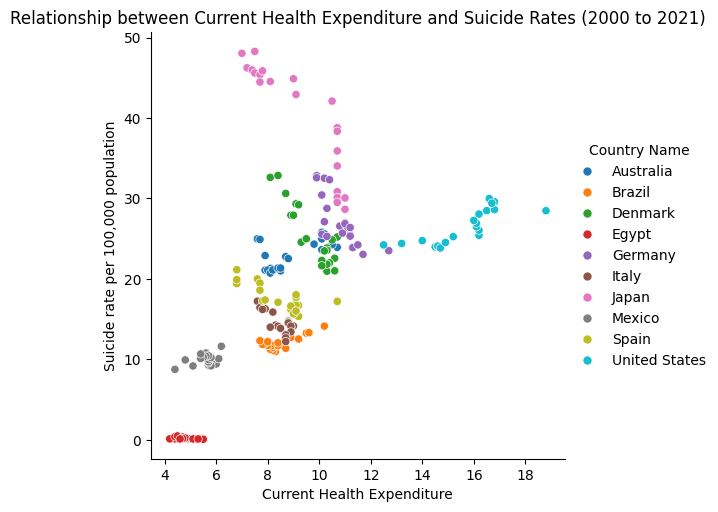

In [22]:
sns.relplot(data=che_data, x="che_gdp", y= "Death rate per 100 000 population", hue="Country Name")
plt.xlabel("Current Health Expenditure")
plt.ylabel("Suicide rate per 100,000 population")
plt.title(f"Relationship between Current Health Expenditure and Suicide Rates ({che_data['Year'].min()} to {che_data['Year'].max()})")
plt.show()

## How do trends in mental health disorders correlate with suicide rates? 


In [21]:
mental_suicide_grouped = mental_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
mental_suicide_merged = mental_suicide_grouped.merge(mental_health_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")
filter_year = mental_suicide_merged[mental_suicide_merged["Year"] == 2016]

fig = px.scatter(filter_year, x="depression", y="Death rate per 100 000 population",
                  text="Country Name",labels ={"depression":"Percentage of People with Depression",
                                                "Death rate per 100 000 population":"Suicide rate per 100 000 population" },
                                                title="Relationship Between Depression and Suicide Rate in 2016")

fig.update_traces(textposition= "top center")
fig.show()